# Deep learning-based optimal filter design for compressed Raman cell type classification 

## Imports

In [39]:
import pandas as pd
from os import listdir
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt 
import seaborn as sns
from BaselineRemoval import BaselineRemoval
import numpy as np
from scipy import sparse
from scipy.sparse.linalg import spsolve
from umap import UMAP

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model

from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

from random import sample

from time import time


## Definitions

In [776]:
# define a colorblind-friendly palette
mypalette = ['xkcd:royal blue','xkcd:orange red','xkcd:golden yellow']

def panel_label(ax,label,fontsize=32):
    """Adds panel to label"""
    ax.text(-0.01, 1.1,label,transform=ax.transAxes,
      fontsize=fontsize, fontweight='bold', va='top', ha='right')

def plot_error(spectra_plot,ax,label,color,error='mad'):
    
    if error == 'mad':
        spectra_median = spectra_plot.median(axis=0)
        spectra_dev = (spectra_plot - spectra_median)

        upper = spectra_median + (spectra_dev*(spectra_dev > 0)).sum(axis=0)/(spectra_dev > 0).sum(axis=0)
        lower = spectra_median - (-spectra_dev*(spectra_dev < 0)).sum(axis=0)/(spectra_dev < 0).sum(axis=0)
        
        spectra_stat = spectra_median

    if error == 'sd':
        spectra_mean = spectra_plot.mean(axis=0)
        spectra_dev = (spectra_plot - spectra_mean)

        upper = spectra_mean + np.sqrt(((spectra_dev*(spectra_dev > 0))**2).sum(axis=0)/(spectra_dev > 0).sum(axis=0)) 
        lower = spectra_mean - np.sqrt(((spectra_dev*(spectra_dev < 0))**2).sum(axis=0)/(spectra_dev < 0).sum(axis=0)) 
        
        spectra_stat = spectra_mean

    
    ax.plot(spectra_plot.columns.values, spectra_stat, label=label,lw=3,color=color)
    ax.plot(spectra_plot.columns.values, lower,color=color, alpha=0.1)
    ax.plot(spectra_plot.columns.values, upper,color=color, alpha=0.1)
    ax.fill_between(spectra_plot.columns.values, lower, upper,color=color,alpha=0.2) 
    

def split_data(spectra):
    
    """
    Split data into Raman intensities and meta data
    """
    
    spectra_ctype = spectra.groupby(['ctype']).mean().iloc[:,:-3]
    spectra_ctype.columns = spectra_ctype.columns.astype(float)
    spectra_ctype_std = spectra.groupby(['ctype']).std().iloc[:,:-3]
    spectra_ctype_std.columns = spectra_ctype_std.columns.astype(float)

    spectra_cell = spectra.groupby(['date','rep','cline','ctype','count']).mean()
    spectra_cell.columns = spectra_cell.columns.astype(float)

    meta = spectra.iloc[:,Nfreq:]
    meta['ctype'] = meta['ctype'].astype('category').cat.reorder_categories(['iPSC','NSC','Neuron'])

    meta_cell = spectra_cell.reset_index().iloc[:,:5]
    meta_cell['ctype'] = meta_cell['ctype'].astype('category').cat.reorder_categories(['iPSC','NSC','Neuron'])

    spectra = spectra.iloc[:,:Nfreq]
    spectra.columns = spectra.columns.astype(float)
    
    return spectra, spectra_cell,spectra_ctype,meta, meta_cell

    
def baseline_als(y, lam, p, niter=10):
    
    """
    Baseline removal by asymmetric least squares smoothing introduced by
    PHC Eilers, HFM Boelens (Leiden University Medical Centre Report 1 (1), 5).
    See also: He, S. et al. Baseline correction for Raman spectra using an improved 
    asymmetric least squares method. Anal Methods-uk 6, 4402–4407 (2014).
    
    PARAMETERS
    y: input data
    lam: prefactor of smoothness penalty term (result is smoother if lam is bigger)
    p: asymmetry parameter; weights on deviations are p if deviation is positive, 1-p
        if deviation is negative
    niter: number of iterations of smoothing procedure; weights are updated in each iteration
        
    RETURNS
    z: smoothed input data 
    """
    
    L = len(y)
    D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
    w = np.ones(L)
    for i in range(niter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
        
    return z


def train_svm(X,y):
    """
    Classifies data using SVM. 
    
    PARAMETERS
    X : input data
    y : classes
    
    RETURNS
    accuracy, index of test samples, correct prediction (boolean)
    
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = svm.SVC()
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)

    return accuracy_score(y_test,y_pred), y_test.index,y_pred==y_test



 
def train_nn(X,y):

    """
    Classifies data using NN 
    
    PARAMETERS
    X : input data
    y : classes
    
    RETURNS
    accuracy, index of test samples, correct prediction (boolean)
    
    """
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    model = keras.models.Sequential([
        keras.Input(shape=(X_train.shape[1],)),
        keras.layers.LayerNormalization(),
        keras.layers.Dense(20,activation="relu"),
        keras.layers.Dense(10,activation="relu"),
        keras.layers.Dense(5,activation="relu"),
        keras.layers.Dense(3,activation="softmax")    
    ])

    model.compile(loss=keras.losses.sparse_categorical_crossentropy,
                  optimizer=keras.optimizers.SGD(learning_rate=0.01),
                  metrics=['accuracy'])
    
    history = model.fit(X_train,y_train,epochs=80,validation_split=0.25,verbose=0,batch_size=5)

    y_pred = model.predict(X_test)
    
    acc = model.evaluate(x=X_test,y=y_test,verbose=0)[1]

    
    return acc,y_test.index,y_test==np.argmax(y_pred,1)


class BinaryWeights(tf.keras.constraints.Constraint):
  """Constrains weight tensors to be either 0 or 1"""

  def __init__(self, wmax=0.1):
    self.wmax = wmax

  def __call__(self,w):
        
    return self.wmax*tf.cast(tf.math.greater_equal(tf.math.abs(w), 0.5*self.wmax), w.dtype)

   

def train_nn_filter(X,y,Nfilters=2,constraint='NonNeg',preweights=None,epochs=20,batch_size=32,verbose=0):

    """
    Classifies spectra using an NN 
    
    PARAMETERS
    X : input data
    y : classes
    
    RETURNS
    accuracy, index of test samples, correct predictions (boolean), weights, history
    
    """
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    if constraint == 'NonNeg':
        const = keras.constraints.NonNeg();
    elif constraint == 'Binary':
        if preweights is None:
            const = BinaryWeights()
        else:
            const = BinaryWeights(wmax = 2*np.mean(preweights[0][:,:]))
    
    
    model = keras.models.Sequential([
        keras.Input(shape=(X_train.shape[1],)),
        keras.layers.Dense(Nfilters,
                         kernel_constraint = const,
                           activation="relu"),
        keras.layers.LayerNormalization(),
        keras.layers.Dense(20,activation="relu"),
        keras.layers.Dense(10,activation="relu"),
        keras.layers.Dense(5,activation="relu"),
        keras.layers.Dense(3,activation="softmax")    
    ])

    model.compile(loss=keras.losses.sparse_categorical_crossentropy,
                  optimizer=keras.optimizers.SGD(learning_rate=0.01),
                  metrics=['accuracy'])

    if not (preweights is None):
        model.set_weights(preweights) 
    
    history = model.fit(X_train,y_train,epochs=epochs,validation_split=0.25,verbose=verbose,batch_size=batch_size)

    y_pred = model.predict(X_test)
    
    acc = model.evaluate(x=X_test,y=y_test,verbose=0)[1]

    
    return acc,y_test.index,y_test==np.argmax(y_pred,1), model.get_weights(), history



def train_nn_bline(X,y,Nfilters=2,constraint='NonNeg',preweights=None,epochs=20,batch_size=32,verbose=0):

    """
    Approximates the baseline a using an NN 
    
    PARAMETERS
    X : input data
    y : classes
    
    RETURNS
    error, weights
    
    """
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    if constraint == 'NonNeg':
        const = keras.constraints.NonNeg();
    elif constraint == 'Binary':
        if preweights is None:
            const = BinaryWeights()
        else:
            const = BinaryWeights(wmax = 2*np.mean(preweights[0][:,:]))

    inputs = keras.Input(shape=(X_train.shape[1],))
    
    branchlist = list()
    
    for i in range(Nfilters):        

        branch = keras.layers.Dense(Nfilters,
                             kernel_constraint = const,
                               activation="relu")(inputs)
        branch = keras.layers.Dense(5,activation='relu')(branch)
        branch = keras.layers.Dense(10,activation='relu')(branch)
        branch = keras.layers.Dense(20,activation='relu')(branch)
        branch = keras.layers.Dense(X_train.shape[1],activation='linear')(branch)
        
        branchlist.append(branch)
    
    outputs = keras.layers.Add()(branchlist)
    
    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(loss=keras.losses.MeanAbsoluteError(),
                  optimizer=keras.optimizers.Adam(learning_rate=0.001),
                  metrics=['mean_absolute_error'])

    if not (preweights is None):
        model.set_weights(preweights) 
    
    history = model.fit(X_train,y_train,epochs=epochs,validation_split=0.25,verbose=verbose,batch_size=batch_size)

    y_pred = model.predict(X_test)
    
    error = model.evaluate(x=X_test,y=y_test,verbose=0)[1]

    
    return error, model.get_weights(), model, history





## Parameters

In [3]:
# preprocessing parameters
lam = 1e6
p = 0.1
Nfreq = 443

# Preprocessing

We use the measured dat from: 
"Hsu, C.-C. et al. A single-cell Raman-based platform to identify developmental stages of human pluripotent stem cell-derived neurons. P Natl Acad Sci Usa 117, 18412–18423 (2020)." We follow Hsu et al and only consider Wavenumbers between 320 $cm^{-1}$ and 1800 $cm^{-1}$ (Fingerprint region). Failed measurements (= all zeros) are removed.

In [150]:
# folder = './litdata/'
# files = listdir(folder)

# alldatraw = pd.DataFrame()
# allblines = pd.DataFrame()
# alldat = pd.DataFrame()


# colnames = ['freq_' +  str(i) for i in range(Nfreq)]

# count = 0
# for file in files:
    
#     count+=1

#     datraw = pd.read_csv(folder+file,sep='\t')

#     # Crop to fingerprint region
#     datraw = datraw.iloc[:,2:(Nfreq+2)]

#     # Remove rows with zeros        
#     datraw = datraw.loc[(datraw > 0).any(axis=1),:]                

#     # Remove baseline from each spectrum
    
#     blines = datraw.apply(lambda x : baseline_als(x,lam,p),axis=1,result_type='broadcast')
#     dat = datraw - blines

#     # Normalize
#     dat = dat.apply(lambda x : x/sum(x),axis=1)

#     for d in [datraw,blines,dat]:
#         d.columns = colnames
#         d['ctype'] = file.split('_')[0]
#         d['cline'] = file.split('_')[1]
#         d['rep'] = file.split('_')[2][1]
#         d['date'] = file.split('_')[3]
#         d['count'] = file.split('_')[4].split('.')[0]        

#     alldatraw = pd.concat([alldatraw,datraw],axis=0,ignore_index=True)
#     allblines = pd.concat([allblines,blines],axis=0,ignore_index=True)
#     alldat = pd.concat([alldat,dat],axis=0,ignore_index=True)


# # use frequencies as column names
# dat = pd.read_csv(folder+files[0],sep='\t')
# alldat.columns.values[:Nfreq] = dat.columns[2:445].values.astype(float)
# allblines.columns.values[:Nfreq] = dat.columns[2:445].values.astype(float)
# alldatraw.columns.values[:Nfreq] = dat.columns[2:445].values.astype(float)

# # save
# alldatraw.to_csv('raman_fingerprint_raw.csv')    
# allblines.to_csv('raman_fingerprint_baselines.csv')    
# alldat.to_csv('raman_fingerprint_processed.csv')    

## Unprocessed spectra

In [40]:
spectra = pd.read_csv('raman_fingerprint_raw.csv',index_col=0)
spectra, spectra_cell,spectra_ctype,meta, meta_cell = split_data(spectra)

## Raw spectra by cell type

In [41]:
spectra_mean_df = pd.DataFrame({'log10(means)' : np.log10(spectra.mean(axis=1)), 'cell type' : meta.ctype})
spectra_combined = spectra.copy()
spectra_combined['cell type'] = meta.ctype
spectra_combined = spectra_combined.melt(id_vars=['cell type'],var_name='freq')
spectra_combined['cell type'].cat.reorder_categories(['iPSC','NSC','Neuron'],inplace=True)

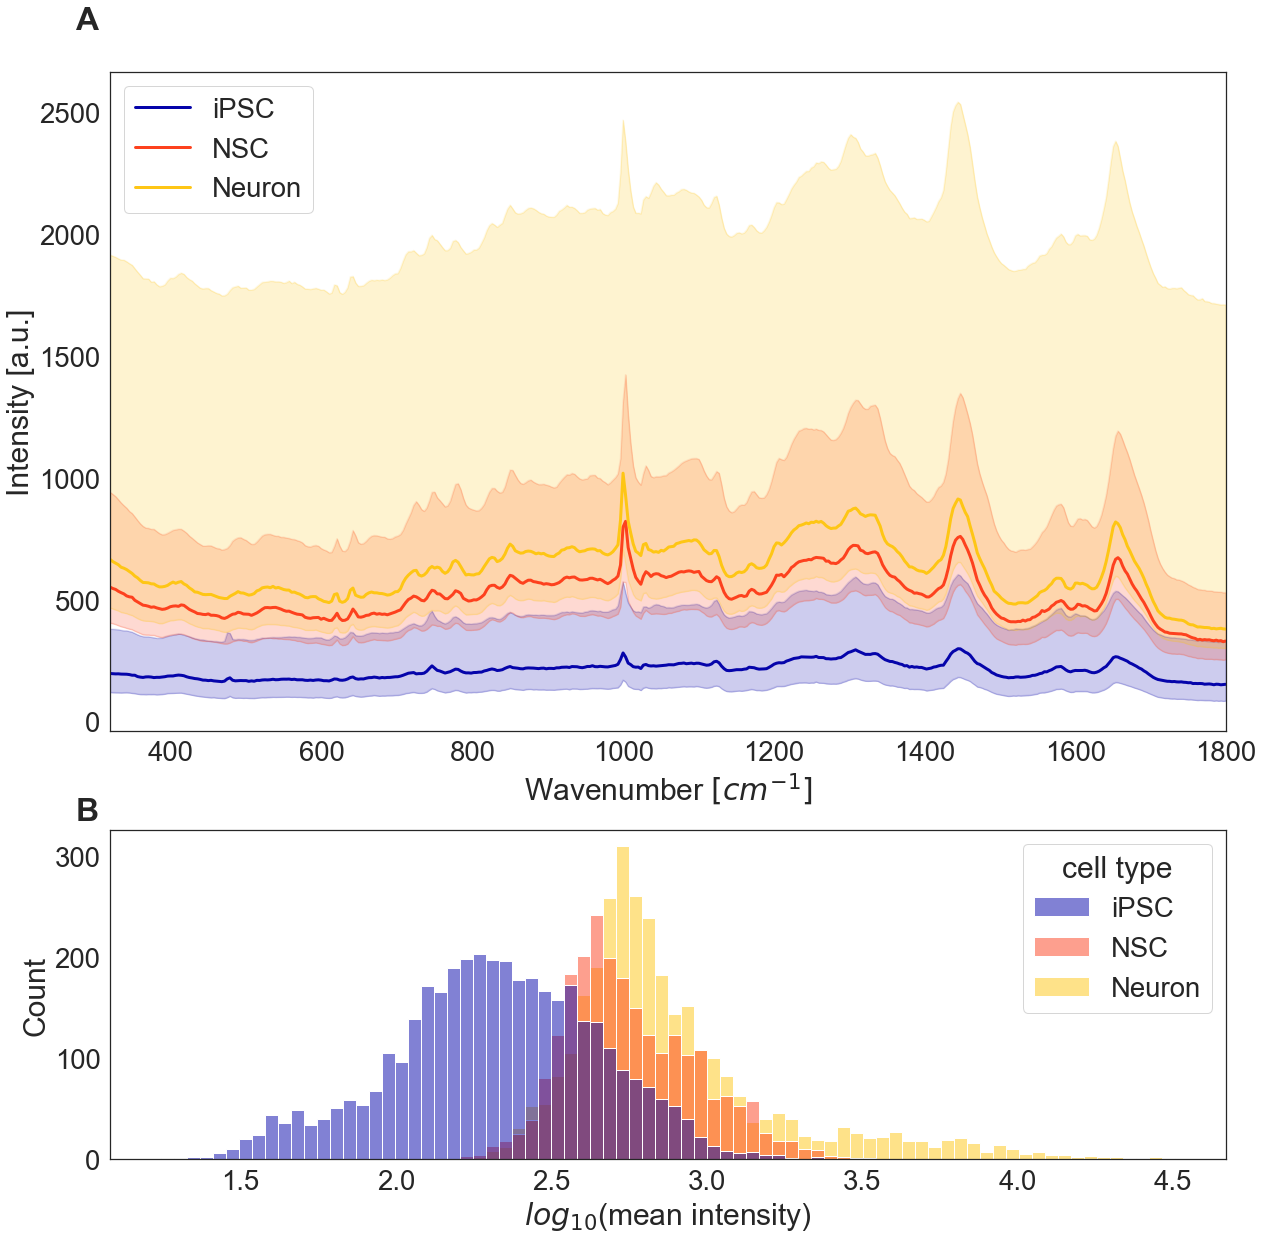

In [42]:
sns.set(style='white',font_scale=2.5)

fig, ax  = plt.subplots(figsize=[20,20],nrows=2,gridspec_kw={'height_ratios': [2, 1]})

panel_label(ax[0],'A')
for ind,ctype in enumerate(['iPSC','NSC','Neuron']):
    plot_error(spectra.loc[meta.ctype==ctype,:],ax[0],ctype,mypalette[ind],error='mad')

ax[0].set_xlabel('Wavenumber $[ cm^{-1} ]$')
ax[0].set_ylabel('Intensity [a.u.]')
ax[0].set_xlim([319,1800])
ax[0].legend()

panel_label(ax[1],'B')
sns.histplot(data=spectra_mean_df,x='log10(means)', hue='cell type',ax=ax[1],palette=mypalette)
ax[1].set_xlabel('$log_{10}$(mean intensity)');

fig.savefig('./figures/Fig1.png')

**Figure 1, Raw Raman spectra**
(A)Raman intensities by cell type before preprocessing The solid lines show the median per cell type for each frequency. The error bands indicate mean absolute deviations calculated separately for positive and negative deviations. (B) Mean intensities of individual Raman spectra before preprocessing.

## Preprocessing example

In [130]:
# load one spectrum as an example
folder = './litdata/'
files = listdir(folder)
dat = pd.read_csv(folder+files[0],sep='\t')

# Crop to fingerprint region
spectrum = dat.iloc[6,2:445]
spectrum.index = spectrum.index.astype(float)

# Calculate baseline
bline = baseline_als(spectrum,lam,p)

# Subtract baseline
spectrum_nobline = spectrum - bline

# Normalize spectrum
spectrum_normalized = spectrum_nobline/sum(spectrum_nobline)


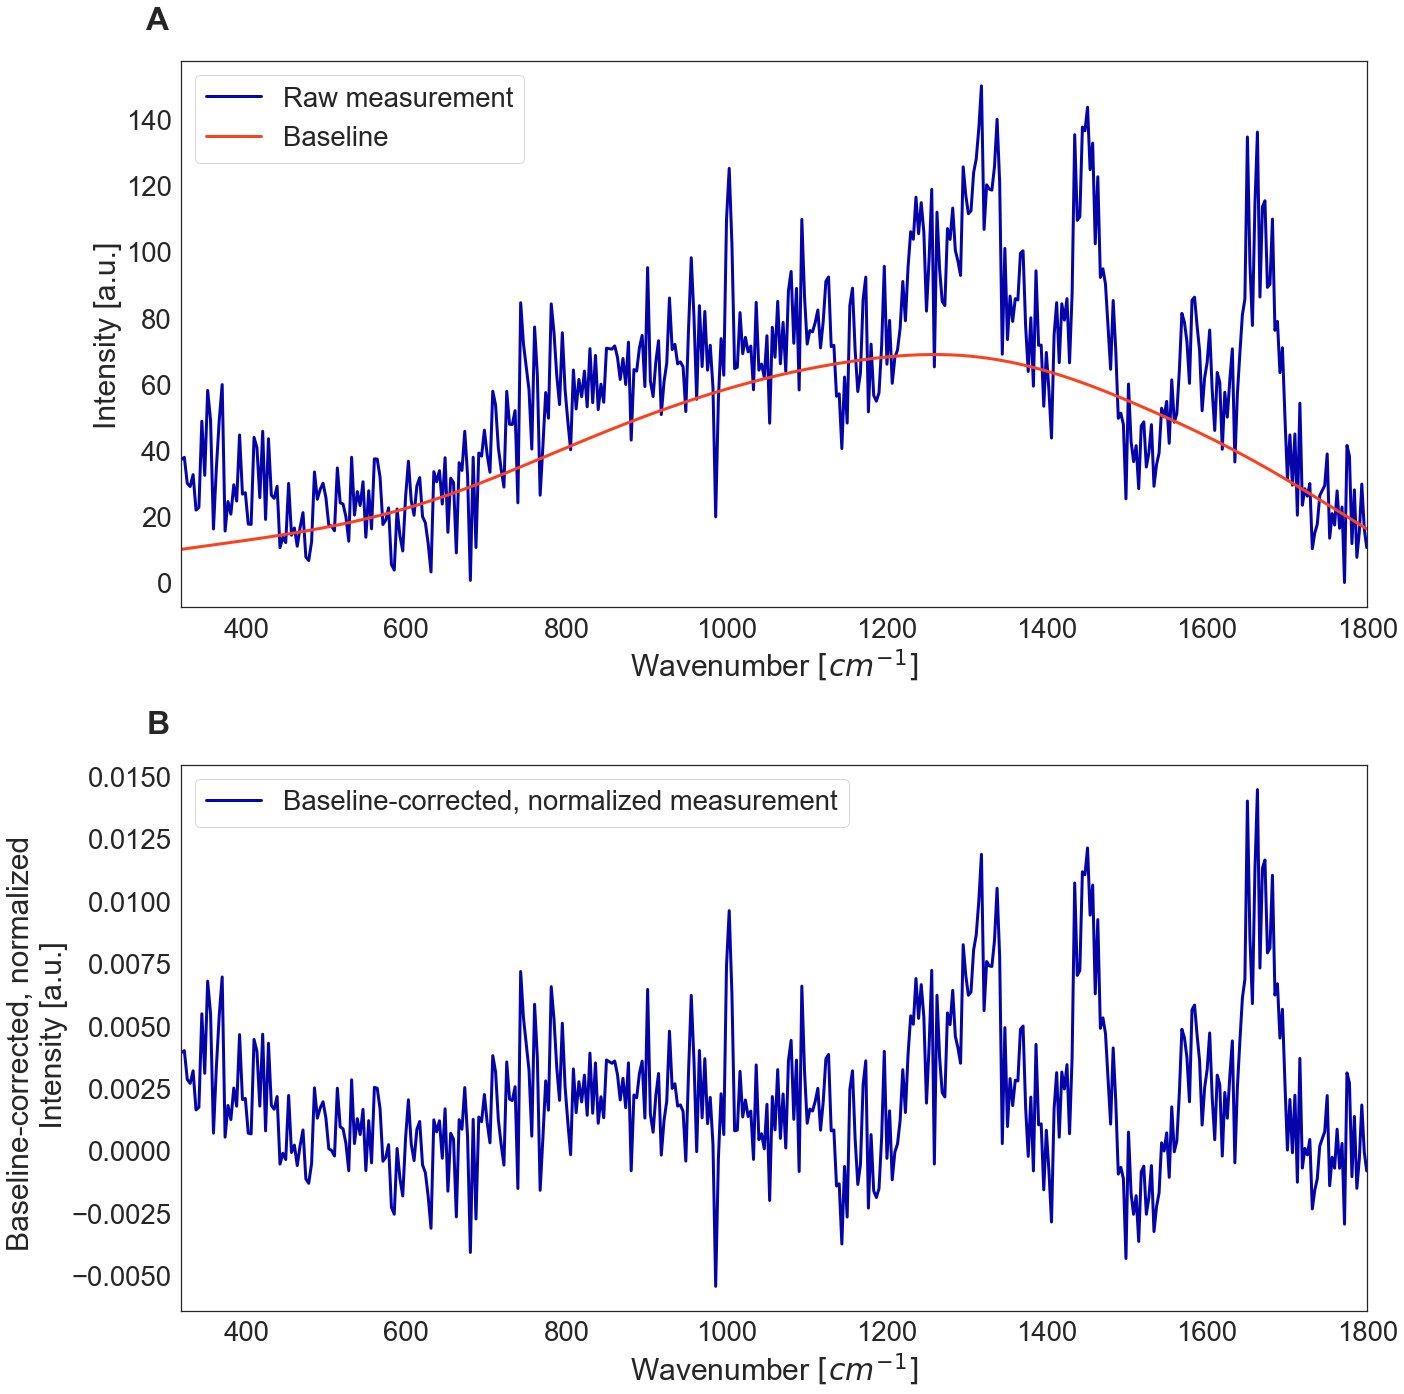

In [131]:
sns.set(style='white',font_scale=2.5)
fig, ax  = plt.subplots(figsize=[20,20],nrows=2)

panel_label(ax[0],'A')
ax[0].plot(spectrum,'-',color='xkcd:royal blue',lw=3,label='Raw measurement')
ax[0].plot(spectrum.index,bline,'-',color='xkcd:orange red',lw=3,label='Baseline')
ax[0].set_xlabel('Wavenumber $[ cm^{-1} ]$')
ax[0].set_ylabel('Intensity [a.u.]')
ax[0].set_xlim([319,1800])
ax[0].legend();

panel_label(ax[1],'B')
ax[1].plot(spectrum_normalized,'-',color='xkcd:royal blue',lw=3,
           label='Baseline-corrected, normalized measurement')
ax[1].set_xlabel('Wavenumber $[ cm^{-1} ]$')
ax[1].set_ylabel('Baseline-corrected, normalized \n Intensity [a.u.]',wrap=True)
ax[1].set_xlim([319,1800])
ax[1].legend();
fig.tight_layout()
fig.savefig('./figures/FigS1.png')

**Figure S1, Preprocessing example**
(A) A baseline calculated by asymmetric least-squares smoothing (red) is subtracted from the raw measurement (blue). (B) The baseline-corrected measurement shown is normalized to the sum of intensities over all considered frequencies.


## Processed spectra by cell type

In [43]:
spectra = pd.read_csv('raman_fingerprint_processed.csv',index_col=0)
spectra, spectra_cell,spectra_ctype,meta, meta_cell = split_data(spectra)

In [44]:
# get number of measurements per cell type
stats_df = pd.DataFrame(meta.groupby('ctype').size()).T
stats_df.columns.name = None
stats_df.index = ['measurements']
stats_df

,iPSC,NSC,Neuron
measurements,3850,2342,3116


In [45]:
# combine spectra and change to long form for visualization
spectra_combined = spectra.copy()
spectra_combined['cell type'] = meta.ctype
spectra_combined = spectra_combined.melt(id_vars=['cell type'],var_name='freq')
spectra_combined['cell type'].cat.reorder_categories(['iPSC','NSC','Neuron'],inplace=True)

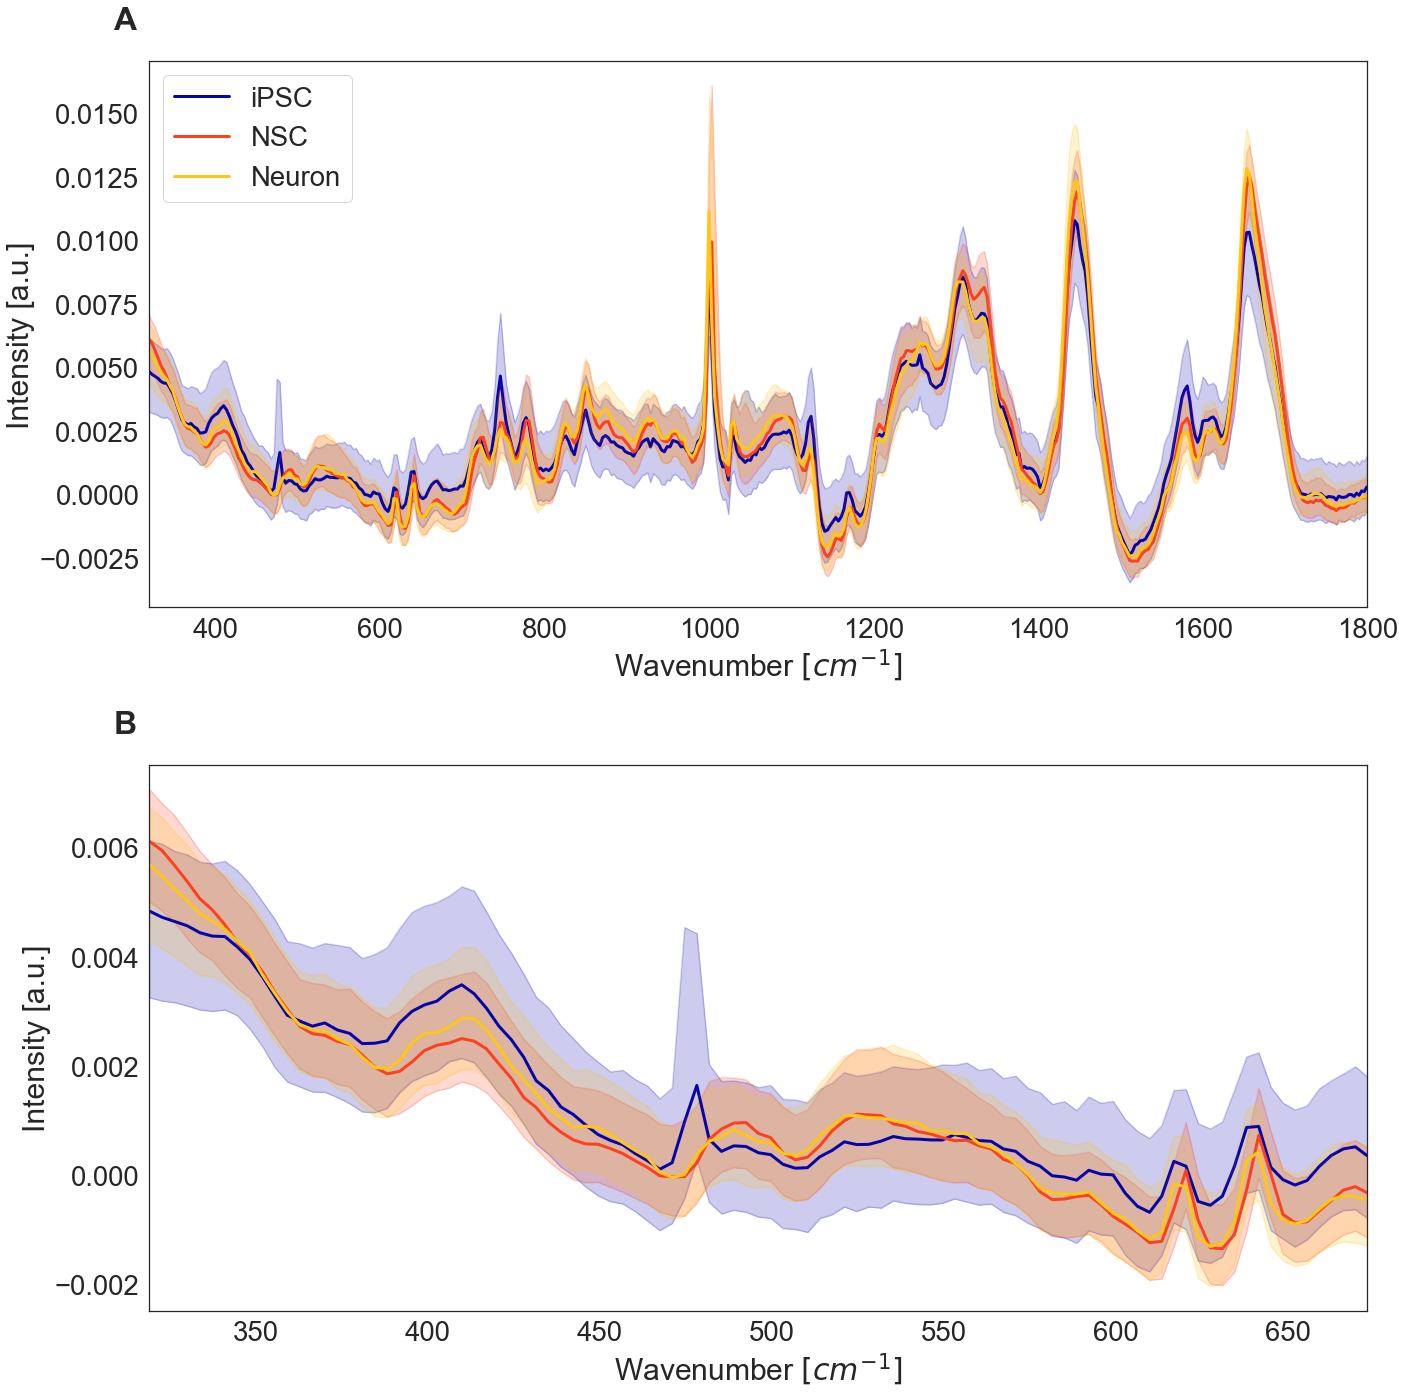

In [46]:
sns.set(style='white',font_scale=2.5)
fig, ax  = plt.subplots(figsize=[20,20],nrows=2)

panel_label(ax[0],'A')
for ind,ctype in enumerate(['iPSC','NSC','Neuron']):
    plot_error(spectra.loc[meta.ctype==ctype,:],ax[0],ctype,mypalette[ind],error='mad')

ax[0].set_xlabel('Wavenumber $[ cm^{-1} ]$')
ax[0].set_ylabel('Intensity [a.u.]')
ax[0].set_xlim([319,1800])
ax[0].legend()

panel_label(ax[1],'B')
for ind,ctype in enumerate(['iPSC','NSC','Neuron']):
    plot_error(spectra.loc[meta.ctype==ctype,:].iloc[:,:100],ax[1],ctype,mypalette[ind],error='mad')
    
ax[1].set_xlabel('Wavenumber $[ cm^{-1} ]$')
ax[1].set_ylabel('Intensity [a.u.]')
ax[1].set_xlim([319,673])
fig.tight_layout()
fig.savefig('./figures/FigS2.png')

**Figure S2, Raman spectra of iPSCs, NSCs and Neurons are strongly overlapping**
Raman spectra after preprocessing (baseline removal and normalization. The solid lines show the medians per cell type (3850 for iPSCS, 2342 for NSCs and 3116 for Neurons). Error bands indicate mean absolute deviation calculated separately for positive and negative deviations. (A) Complete fingerprint region. (B) Zoom in on 319  to 673 $cm^{-1}$.

# Classification based on complete spectra

In [4]:
spectra = pd.read_csv('raman_fingerprint_processed.csv',index_col=0)
spectra, spectra_cell,spectra_ctype,meta, meta_cell = split_data(spectra)

In [5]:
# code cell types as integers
y = meta['ctype'].map({'iPSC' : 0 , 'NSC' : 1, 'Neuron' :2}).astype('uint8')

# base accuracy: naive model always picking the must abundant class
base_acc = max(meta.groupby(by='ctype').count().iloc[:,0])/meta.shape[0]

## PCA and tSNE

In [6]:
pca = PCA(n_components=10).fit_transform(spectra)

pca_df = pd.DataFrame(pca[:,:2])
pca_df.columns = ['PC1','PC2']
pca_df['cell type'] = meta['ctype']

tsne_map = TSNE().fit_transform(pca)
tsne_map_df = pd.DataFrame(tsne_map)
tsne_map_df.columns = ['tSNE1','tSNE2']
tsne_map_df['cell type'] = meta['ctype']


## Training

In [41]:
start = time()
acc_svm,index_svm,is_correct_svm = train_svm(spectra,y)
acc_nn,index_nn,is_correct_nn = train_nn(spectra,y)

stop=time()

print(stop-start)
# [acc_svm,acc_nn]

142.54913520812988


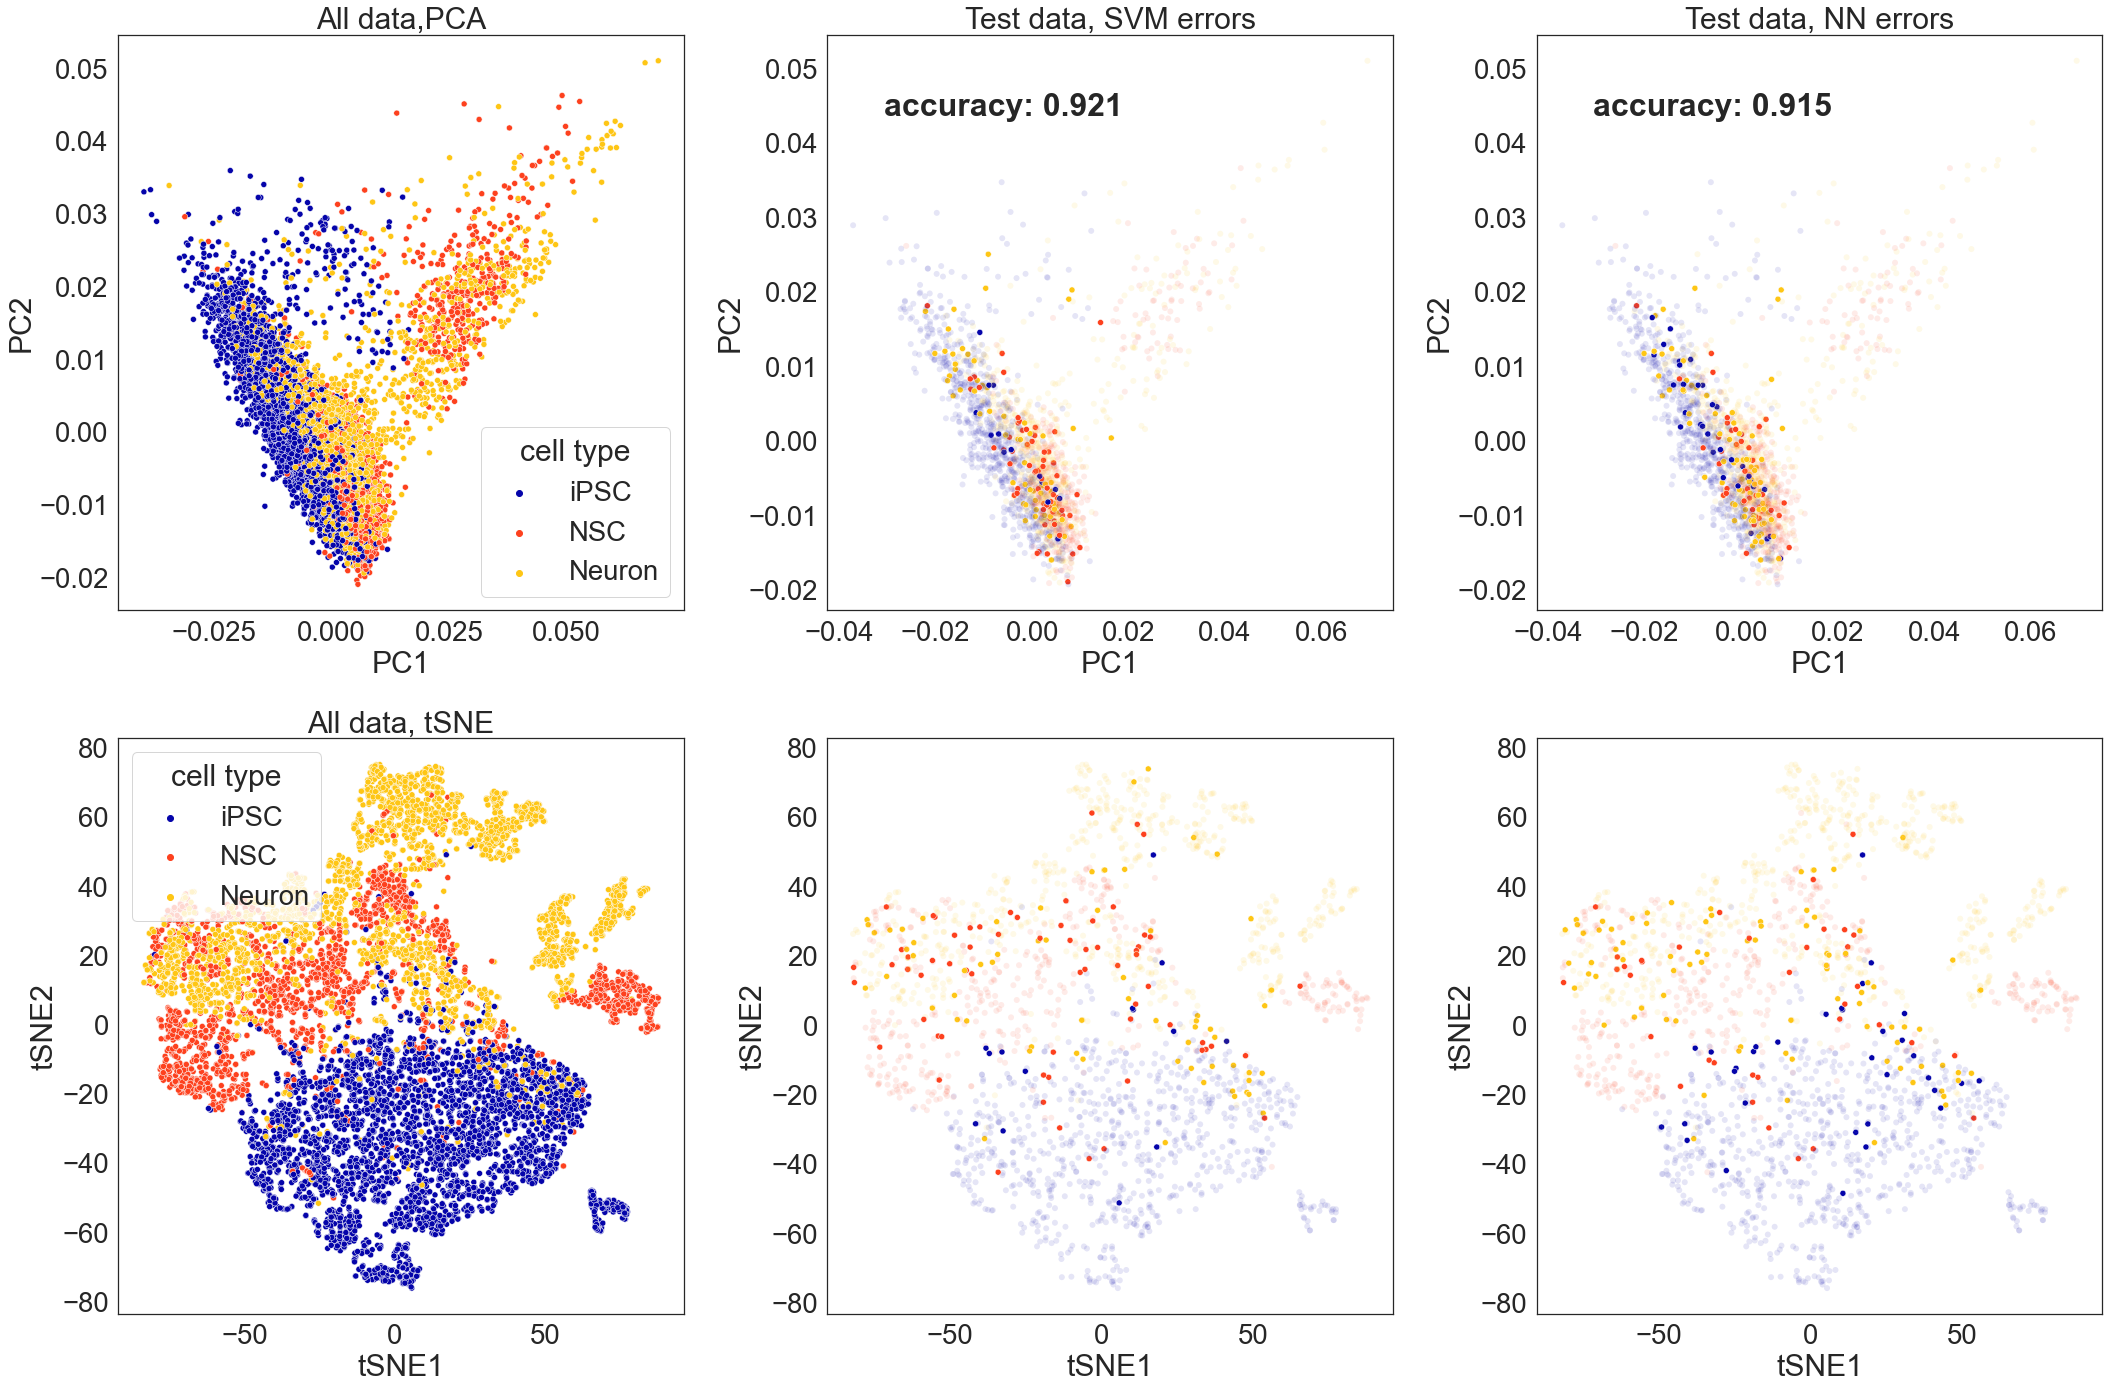

In [8]:
sns.set(style='white',font_scale=2.5)

fig,ax  = plt.subplots(figsize=[30,20],nrows=2,ncols=3)

# show dim reduction

sns.scatterplot(data=pca_df,x='PC1',y='PC2',hue='cell type',ax=ax[0,0],palette = mypalette);
ax[0,0].set_title('All data,PCA')

sns.scatterplot(data=tsne_map_df,x='tSNE1',y='tSNE2',hue='cell type',palette = mypalette,ax=ax[1,0])
ax[1,0].set_title('All data, tSNE')

# wrong predictions SVM

pca_test_df = pca_df.loc[index_svm,:]

alpha = np.ones(pca_test_df.shape[0])
alpha[is_correct_svm] = 0.1

sns.scatterplot(data=pca_test_df,x='PC1',y='PC2',hue='cell type',ax=ax[0,1],palette = mypalette,alpha=alpha)
ax[0,1].set_title('Test data, SVM errors');
ax[0,1].text(0.1, 0.9,'accuracy: '+str(np.round(acc_svm,3)),transform=ax[0,1].transAxes,
      fontsize=32, fontweight='bold', va='top', ha='left')
ax[0,1].get_legend().remove()

tsne_map_test_df = tsne_map_df.loc[index_svm,:]

sns.scatterplot(data=tsne_map_test_df,x='tSNE1',y='tSNE2',hue='cell type',palette = mypalette,ax=ax[1,1],alpha=alpha)
ax[1,1].get_legend().remove()

# wrong predictions NN

pca_test_df = pca_df.loc[index_nn,:]

alpha = np.ones(pca_test_df.shape[0])
alpha[is_correct_nn] = 0.1

sns.scatterplot(data=pca_test_df,x='PC1',y='PC2',hue='cell type',ax=ax[0,2],palette = mypalette,alpha=alpha)
ax[0,2].set_title('Test data, NN errors');
ax[0,2].text(0.1, 0.9,'accuracy: '+str(np.round(acc_nn,3)),transform=ax[0,2].transAxes,
      fontsize=32, fontweight='bold', va='top', ha='left')
ax[0,2].get_legend().remove()

tsne_map_test_df = tsne_map_df.loc[index_nn,:]

sns.scatterplot(data=tsne_map_test_df,x='tSNE1',y='tSNE2',hue='cell type',palette = mypalette,ax=ax[1,2],alpha=alpha)
ax[1,2].get_legend().remove()

plt.tight_layout()

fig.savefig('./figures/FigS3.png')


**Figure S3, Support vector machines and neural networks classify cell types with high accuracy**
Supervised classification based on the complete Raman spectra in the fingerprint region. The first row shows the data projected on the first two principal components. The second row shows a two dimensional tSNE (t-distributed stochastic neighbor embedding). The second and third columns only show the test samples with the samples wrongly predicted by support vector classification or neural networks highlighted. 



# Classification based on spectra subsets or binned spectra 

### Subset of frequencies
SVM and NN classification using a subset of frequencies or frequency bands according to variability

In [9]:
# fraction of frequencies with highest variability
tops = [0.001,0.0025,0.005,0.01,0.02,0.03,0.04,0.05,0.1,0.2,0.5,1]

In [10]:
std = spectra_ctype.std(axis=0)

top_freqs_df = pd.DataFrame(columns = ['top','freq'])

for top in tops:
    q = np.quantile(std,1-top)
    top_freqs = std[std >= q].index.values #[np.int(s.split('_')[1]) for s in ]

    top_freqs_df = pd.concat([top_freqs_df,
                              pd.DataFrame( {'top' : top*np.ones(len(top_freqs)), 'freq' : top_freqs})])


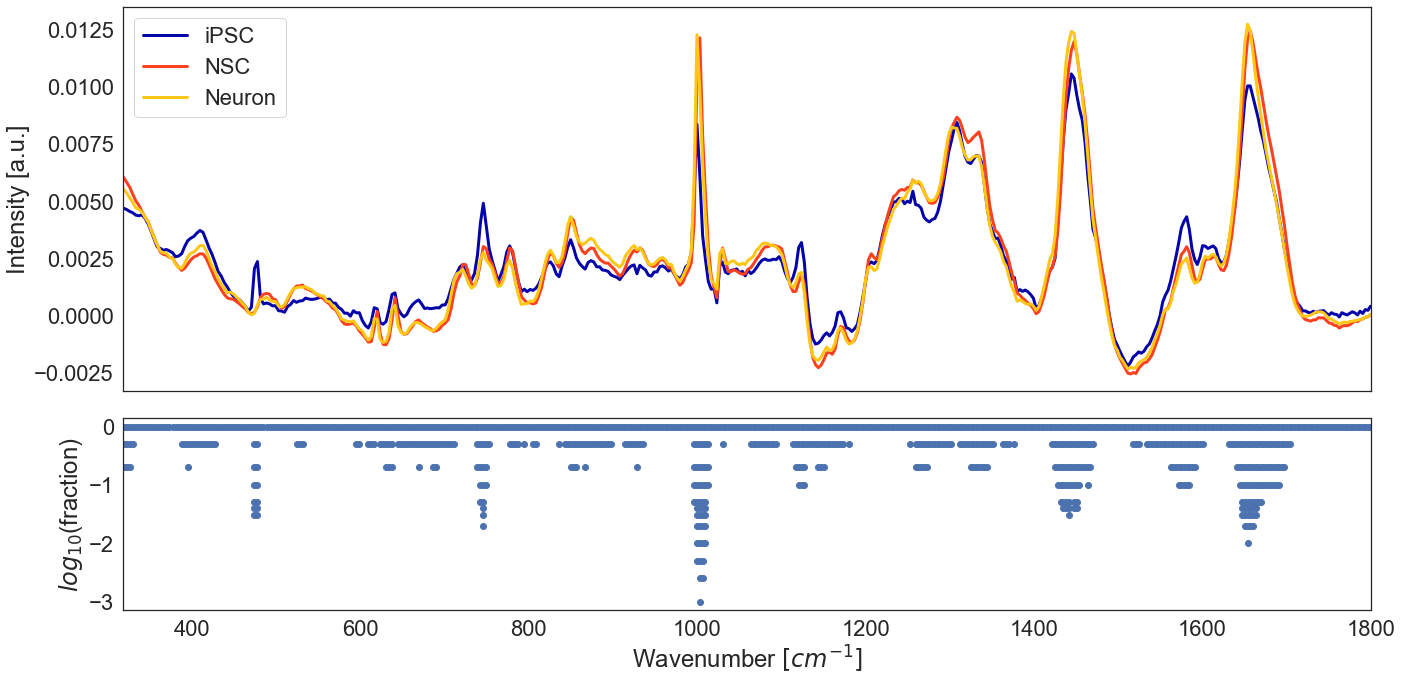

In [11]:
sns.set(style='white',font_scale=2)

fig, ax  = plt.subplots(figsize=[20,10],nrows=2,sharex=True,gridspec_kw={'height_ratios': [2, 1]})

ax[0].plot(spectra_ctype.loc['iPSC',:],'-',color=mypalette[0],lw=3,label='iPSC');
ax[0].plot(spectra_ctype.loc['NSC',:],'-',color=mypalette[1],lw=3,label='NSC');
ax[0].plot(spectra_ctype.loc['Neuron',:],'-',color=mypalette[2],lw=3,label='Neuron');
ax[0].set_xlim([319,1800])
ax[0].set_ylabel('Intensity [a.u.]')
ax[0].legend()

ax[1].plot(top_freqs_df['freq'],np.log10(top_freqs_df['top']),'o')
ax[1].set_xlim([319,1800])
ax[1].set_xlabel('Wavenumber $[ cm^{-1} ]$')
ax[1].set_ylabel('$log_{10}$(fraction)')

plt.tight_layout()

fig.savefig('./figures/FigS4.png')

**Figure S4, Identification of most informative frequencies**
Top: Average Raman spectra for each cell type. Bottom: Frequencies with the most variable intensity across average spectra (standard deviation). The fraction of included frequencies is indicated on the y-axis.

In [12]:
std = spectra_ctype.std(axis=0) 


mod = ['svm','nn']
freqchoice = ['best','random']

acc = { m : {f : list() for f in freqchoice} for m in mod}

allNtop = list()


for top in tops:
    
    print(top)
    
    # choose frequencies wit most variable signal
    q = np.quantile(std,1-top)
    is_top_freq = (std >= q).values
    Ntop = sum(is_top_freq)
    allNtop.append(Ntop)
    
    for m in mod:
        for f in freqchoice:
            
            if f == 'best':
                X_top = spectra.loc[:,is_top_freq]
            else:
                X_top = spectra.sample(n=Ntop,axis='columns')
            
    
            if m == 'svm':
                acc_model, test_index, is_correct = train_svm(X_top,y)
            else:
                acc_model, test_index, is_correct = train_nn(X_top,y)
            
            acc[m][f].append(acc_model)

acc_df = pd.DataFrame({'SVM,best' : acc['svm']['best'], 'SVM,random' : acc['svm']['random'],
          'NN,best' : acc['nn']['best'], 'NN,random' : acc['nn']['random']},index=allNtop)



0.001
0.0025
0.005
0.01
0.02
0.03
0.04
0.05
0.1
0.2
0.5
1


### Binning and averaging

In [13]:
# size of frequency interval
deltas = [1,5,10,20,40,80,100,200,400]

acc_bin = { m : list() for m in mod}
allNbin = list()

for delta in deltas:

    print(delta)

    
    # average over frequency bands for individual spectra        
    spec_mean = pd.DataFrame()

    for i in range(np.int(spectra.shape[1]/delta)):
        spec_mean[i] = spectra.iloc[:,delta*i:min([spectra.shape[1],delta*(i+1)])].mean(axis=1)

    
    acc_model, test_index, is_correct = train_svm(spec_mean,y)
    acc_bin['svm'].append(acc_model)
    acc_model, test_index, is_correct = train_nn(spec_mean,y)
    acc_bin['nn'].append(acc_model)
            
    allNbin.append(spec_mean.shape[1])

    
acc_bin_df = pd.DataFrame({'SVM,binned' : acc_bin['svm'],'NN,binned' : acc_bin['nn']},index=allNbin)




1
5
10
20
40
80
100
200
400


Compare approaches

In [14]:
all_acc_df = pd.concat([acc_df,acc_bin_df]).reset_index().sort_values(by='index').melt(id_vars=['index'])
all_acc_df.iloc[:,0] = np.log10(all_acc_df.iloc[:,0]) 
all_acc_df.columns = ['log10_N_measurements','Approach','Accuracy']
all_acc_df['model'] = [s.split(',')[0] for s in all_acc_df.Approach]
all_acc_df['selection'] = [s.split(',')[1] for s in all_acc_df.Approach]
all_acc_df.drop('Approach',axis=1,inplace=True)

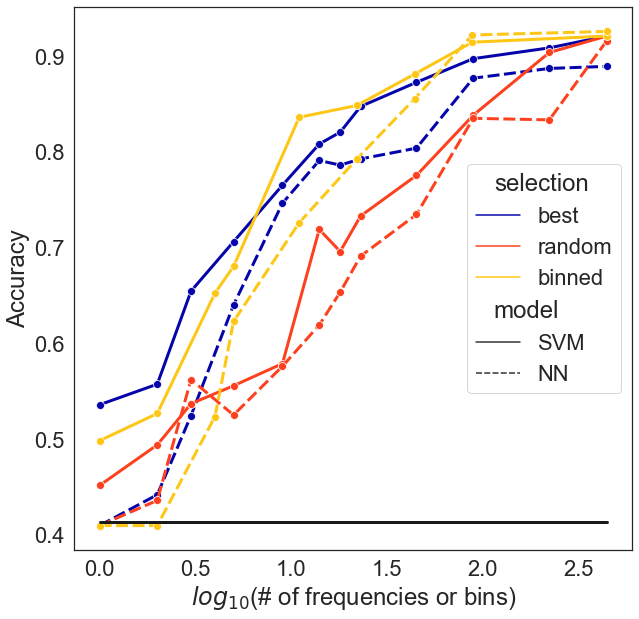

In [15]:
sns.set(style='white',font_scale=2)
fig,ax = plt.subplots(figsize=[10,10])
sns.lineplot(data=all_acc_df.sort_values(by='log10_N_measurements'),x='log10_N_measurements',y='Accuracy',hue='selection',
             style= 'model',marker='o',markersize=8,lw=3,palette=mypalette,ax=ax)
ax.plot([0,np.log10(Nfreq)],[base_acc,base_acc],'k-',lw=3);
ax.set_xlabel('$log_{10}$(# of frequencies or bins)');
fig.savefig('./figures/Fig2.png')

**Figure 3, Classification performance increases with number of included frequencies or frequency bins**
Accuracy on a held-out test set of for the support vector machine (SVM) or neural network (NN) model. For the results labeled 'best' or 'random', a subset of frequencies was chosen either based on most variable freqencies ('best') or randomly ('random'). For the results labeled 'binned' Raman intensities were binned in equally sized bins and averaged. The solid horizontal line indicates the base accuracy corresponding to a naive model that always predicts the most abundant class.

# Optimal filter design with an NN

Idea: constrain weights in input layer of NN to be at least non-negative, but ideally also binary, so that they can be implemented in a physical optical filter

### Using the raw data directly

In [16]:
spectra = pd.read_csv('raman_fingerprint_raw.csv',index_col=0)
spectra, spectra_cell,spectra_ctype,meta, meta_cell = split_data(spectra)

In [17]:
X = spectra
y = meta['ctype'].map({'iPSC' : 0 , 'NSC' : 1, 'Neuron' :2}).astype('uint8')

# base accuracy: naive model always picking the must abundant class
base_acc = max(meta.groupby(by='ctype').count().iloc[:,0])/meta.shape[0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
# try SVM for comparison
acc_svm,index_svm,is_correct_svm = train_svm(X,y)
acc_svm

0.6740064446831364

In [ ]:
Nfilters = [1,2,3,4,5,10,15,20,50,100,400]

AI_acc_df = pd.DataFrame(index= Nfilters,columns = ['non negative','binary'] )

for Nfilt in Nfilters:
    
    print(Nfilt)
    
    acc_first_model, test_index, is_correct, weights, history = train_nn_filter(X,y,Nfilters=Nfilt,epochs=100,batch_size=5)
    acc_second_model, test_index, is_correct, weights, history = train_nn_filter(X,y,Nfilters=Nfilt,constraint='Binary',preweights=weights,
                                                                                 epochs=100,batch_size=5)

    AI_acc_df.loc[Nfilt,'non negative'] = acc_first_model
    AI_acc_df.loc[Nfilt,'binary'] = acc_second_model
    

In [ ]:
AI_acc_plot_df = AI_acc_df.reset_index().sort_values(by='index').melt(id_vars=['index'])
AI_acc_plot_df['log10_N_measurements'] = np.log10(AI_acc_plot_df['index'])
AI_acc_plot_df.drop('index',axis=1,inplace=True)

# AI_acc_df = pd.DataFrame({'log10_N_measurements': np.log10(Nfilters),'Approach' : 'AI','Accuracy' : AI_acc})
# AI_acc_plot_df

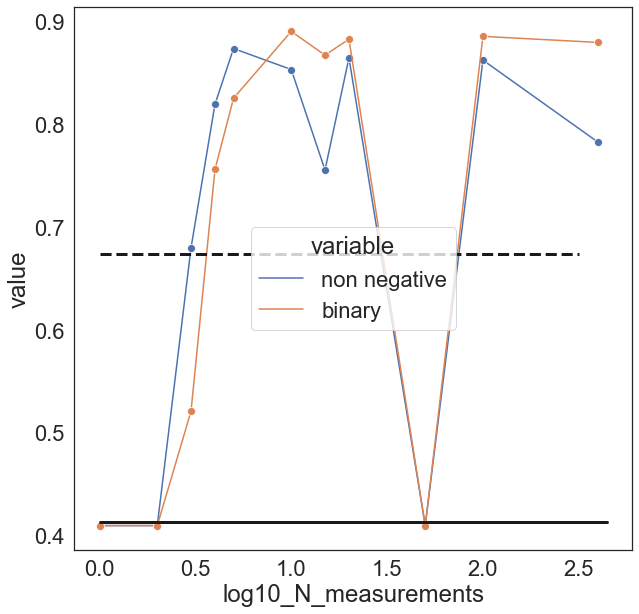

In [36]:
fig,ax = plt.subplots(figsize=[10,10])
sns.lineplot(data=AI_acc_plot_df.sort_values(by='log10_N_measurements'),x='log10_N_measurements',y='value',hue='variable'
             ,marker='o',markersize=8,ax=ax)

ax.plot([0,2.5],[acc_svm,acc_svm],'k--',lw=3);
ax.plot([0,np.log10(Nfreq)],[base_acc,base_acc],'k-',lw=3);


### Baseline estimation

In [227]:
spectra = pd.read_csv('raman_fingerprint_raw.csv',index_col=0)
spectra, spectra_cell,spectra_ctype,meta, meta_cell = split_data(spectra)
blines = pd.read_csv('raman_fingerprint_baselines.csv',index_col=0)
blines, blines_cell,blines_ctype,meta, meta_cell = split_data(blines)

Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20


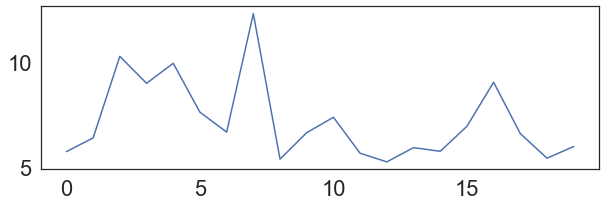

In [784]:
Nfilters = 5
error, weights, model, history = train_nn_bline(spectra,blines,epochs=20,verbose=3,Nfilters=Nfilters)
error, weights, model_baseline, history = train_nn_bline(spectra,blines,preweights=weights,constraint='Binary',epochs=20,verbose=3,Nfilters=Nfilters)

fig,ax = plt.subplots(figsize=[10,3])
ax.plot(history.epoch, history.history['val_mean_absolute_error'])

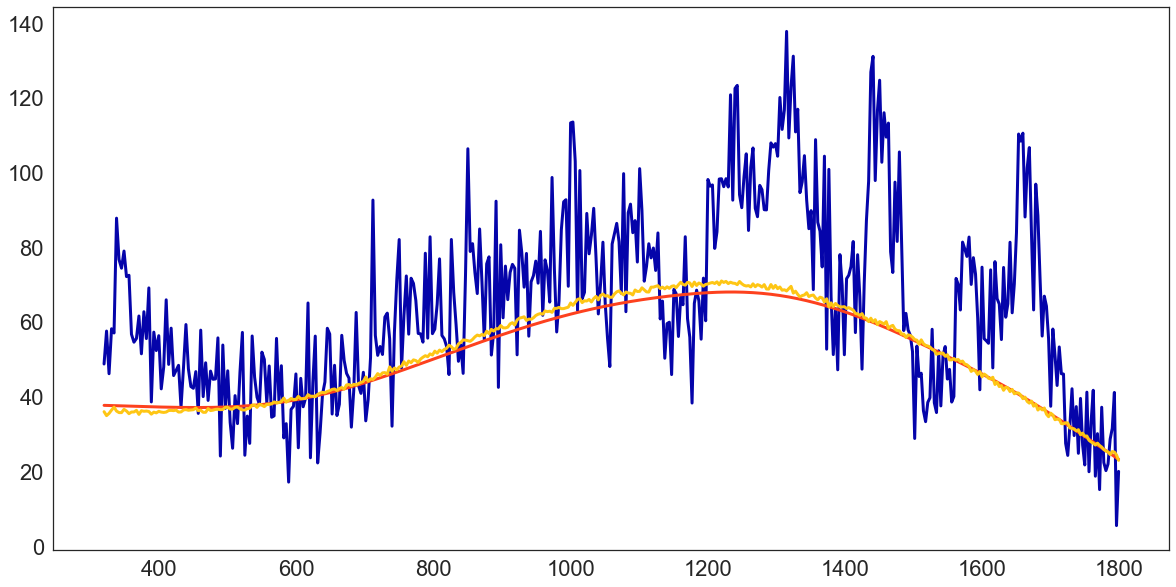

In [785]:
example = 15

sns.set(style='white',font_scale=2)

fig, ax  = plt.subplots(figsize=[20,10],sharex=True)

ax.plot(spectra.iloc[example,:],'-',color=mypalette[0],lw=3);
ax.plot(blines.iloc[example,:],'-',color=mypalette[1],lw=3);

ax.plot(blines.columns,model_baseline.predict(pd.DataFrame(spectra.iloc[example,:]).T).T,'-',color=mypalette[2],lw=3)



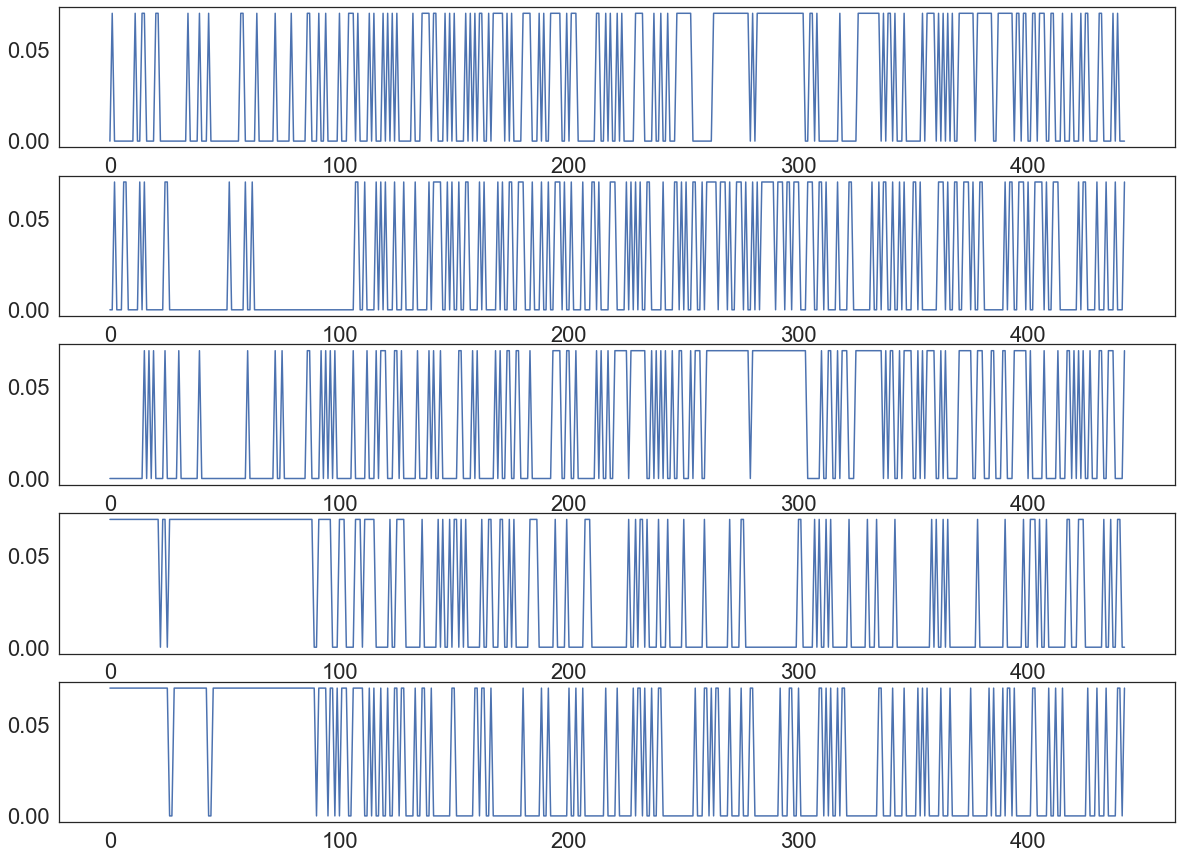

In [786]:
fig,ax = plt.subplots(figsize=[20,3*Nfilters],nrows=Nfilters)

for i in range(Nfilters):
    ax[i].plot(weights[0][:,i])

### Classification with baseline

In [787]:
spectra = pd.read_csv('raman_fingerprint_raw.csv',index_col=0)
spectra, spectra_cell,spectra_ctype,meta, meta_cell = split_data(spectra)

In [788]:
X = spectra
y = meta['ctype'].map({'iPSC' : 0 , 'NSC' : 1, 'Neuron' :2}).astype('uint8')

# base accuracy: naive model always picking the must abundant class
base_acc = max(meta.groupby(by='ctype').count().iloc[:,0])/meta.shape[0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [831]:
def train_nn_filter_with_bline(X,y,model_baseline,Nfilters=2,constraint='NonNeg',preweights=None,epochs=20,batch_size=32,verbose=0):

    """
    Classifies spectra using an NN 
    
    PARAMETERS
    X : input data
    y : classes
    
    RETURNS
    accuracy, index of test samples, correct predictions (boolean), weights, history
    
    """
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # make baseline model constant
    for layer in model_baseline.layers:
        layer.trainable = False
    
    
    if constraint == 'NonNeg':
        const = keras.constraints.NonNeg();
    elif constraint == 'Binary':
        if preweights is None:
            const = BinaryWeights()
        else:
            const = BinaryWeights(wmax = 2*np.mean(preweights[0][:,:]))
    

    
    inputs = keras.Input(shape=(X_train.shape[1],))
    
    filter_layer = keras.layers.Dense(Nfilters,
                         kernel_constraint = const,
                           activation="relu")
    
    branch1 = filter_layer(inputs)
    branch2 = filter_layer(model_baseline(inputs))
    branch = keras.layers.Subtract()([branch1,branch2])
    branch = keras.layers.LayerNormalization()(branch)
    branch = keras.layers.Dense(20,activation='relu')(branch)
    branch = keras.layers.Dense(10,activation='relu')(branch)
    branch = keras.layers.Dense(5,activation='relu')(branch)
    branch = keras.layers.Dense(3,activation='softmax')(branch)
    
    model = keras.Model(inputs=inputs, outputs=branch)
    
    model.compile(loss=keras.losses.sparse_categorical_crossentropy,
                  optimizer=keras.optimizers.SGD(learning_rate=0.01),
                  metrics=['accuracy'])

    if not (preweights is None):
        model.set_weights(preweights) 
    
    history = model.fit(X_train,y_train,epochs=epochs,validation_split=0.25,verbose=verbose,batch_size=batch_size)

    y_pred = model.predict(X_test)
    
    acc = model.evaluate(x=X_test,y=y_test,verbose=0)[1]

    
    return acc,y_test.index,y_test==np.argmax(y_pred,1), model.get_weights(), history


In [833]:
Nfilters = 5
acc_first_model, test_index, is_correct, weights, history = train_nn_filter_with_bline(X,y,model_baseline,
                                                                                       Nfilters=Nfilters,verbose=2,epochs=40,batch_size=5)

# acc_first_model, test_index, is_correct, weights, history = train_nn_filter_with_bline(X,y,model_baseline,
#                                                                                        preweights=weights,constraint='Binary',
#                                                                                        Nfilters=Nfilters,verbose=2,epochs=40,batch_size=5)



Epoch 1/40
1117/1117 - 3s - loss: 0.8412 - accuracy: 0.5693 - val_loss: 0.5401 - val_accuracy: 0.7191
Epoch 2/40
1117/1117 - 2s - loss: 0.5120 - accuracy: 0.7530 - val_loss: 0.3532 - val_accuracy: 0.8357
Epoch 3/40
1117/1117 - 2s - loss: 0.3875 - accuracy: 0.8349 - val_loss: 0.2467 - val_accuracy: 0.9270
Epoch 4/40
1117/1117 - 2s - loss: 0.3023 - accuracy: 0.8750 - val_loss: 0.2009 - val_accuracy: 0.9361
Epoch 5/40
1117/1117 - 2s - loss: 0.2696 - accuracy: 0.8920 - val_loss: 0.1978 - val_accuracy: 0.9372
Epoch 6/40
1117/1117 - 2s - loss: 0.2401 - accuracy: 0.9088 - val_loss: 0.5463 - val_accuracy: 0.7970
Epoch 7/40
1117/1117 - 2s - loss: 0.2342 - accuracy: 0.9078 - val_loss: 0.2022 - val_accuracy: 0.9275
Epoch 8/40
1117/1117 - 2s - loss: 0.2119 - accuracy: 0.9176 - val_loss: 0.1982 - val_accuracy: 0.9280
Epoch 9/40
1117/1117 - 2s - loss: 0.2000 - accuracy: 0.9205 - val_loss: 0.2847 - val_accuracy: 0.8824
Epoch 10/40
1117/1117 - 2s - loss: 0.1864 - accuracy: 0.9277 - val_loss: 0.1930 - 

# Next steps

1. This model seems to be not so robust! Run repeatedy and plot distribution

2. Train separate model to estimate baseline (input: raw data, output: baseline).  Subtract estimated (estimated baseline  x weights of first layer in classification model) from (raw data x weights of first layer in classiication model) 


In [772]:
def asymmetric_mae(p=0.1,lam=1):
    
    def loss(y_true, y_pred):
    
        diff = y_true - y_pred
        asymdiff = tf.where(tf.greater_equal(diff, 0), np.sqrt(p)*diff, np.sqrt((1-p))*diff)
        data_loss = tf.reduce_mean(tf.abs(asymdiff), axis=-1)

        smooth_loss = lam*tf.reduce_mean(tf.abs(y_pred[:,2:] - 2*y_pred[:,1:-1] + y_pred[:,0:-2]),axis=-1)

        return data_loss + smooth_loss
    
    return loss




Model: "sequential_234"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1596 (Dense)           (None, 5)                 2220      
_________________________________________________________________
dense_1597 (Dense)           (None, 5)                 30        
_________________________________________________________________
dense_1598 (Dense)           (None, 10)                60        
_________________________________________________________________
dense_1599 (Dense)           (None, 20)                220       
_________________________________________________________________
dense_1600 (Dense)           (None, 443)               9303      
Total params: 11,833
Trainable params: 11,833
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20
175/175 - 2s - loss: 88.8910 - mean_absolute_error: 88.8910 - val_loss: 30.2720 - val_mean_absolute_error: 30.2720
Epoch 2/20
175/175 - 1s - loss: 24.4929 - mean_absolute_error: 24.4929 - val_loss: 16.7891 - val_mean_absolute_error: 16.7891
Epoch 3/20
175/175 - 0s - loss: 18.5975 - mean_absolute_error: 18.5975 - val_loss: 15.8044 - val_mean_absolute_error: 15.8044
Epoch 4/20
175/175 - 0s - loss: 18.5933 - mean_absolute_error: 18.5933 - val_loss: 15.7422 - val_mean_absolute_error: 15.7422
Epoch 5/20
175/175 - 0s - loss: 13.0106 - mean_absolute_error: 13.0106 - val_loss: 15.6932 - val_mean_absolute_error: 15.6932
Epoch 6/20
175/175 - 0s - loss: 13.5630 - mean_absolute_error: 13.5630 - val_loss: 10.0282 - val_mean_absolute_error: 10.0282
Epoch 7/20
175/175 - 1s - loss: 15.1333 - mean_absolute_error: 15.1333 - val_loss: 10.0395 - val_mean_absolute_error: 10.0395
Epoch 8/20
175/175 - 1s - loss: 10.3296 - mean_absolute_error: 10.3296 - val_loss: 9.5420 - val_mean_absolute_error: 9

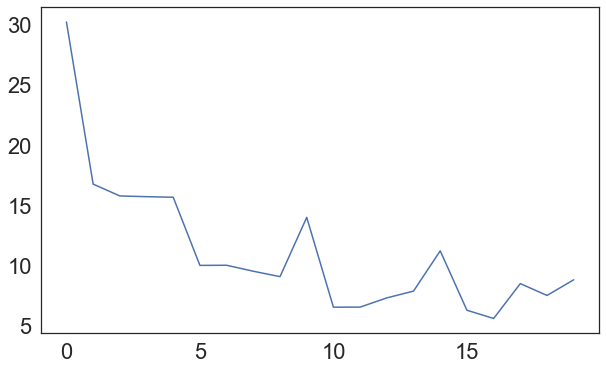

In [773]:
Nfilters = 5
error, weights, model, history = train_nn_bline(spectra,blines,epochs=20,verbose=2,Nfilters=Nfilters)

fig,ax = plt.subplots(figsize=[10,6])
ax.plot(history.epoch, history.history['val_mean_absolute_error'])


In [ ]:
example = 10

sns.set(style='white',font_scale=2)

fig, ax  = plt.subplots(figsize=[20,10],sharex=True)

ax.plot(spectra.iloc[example,:],'-',color=mypalette[0],lw=3);
ax.plot(blines.iloc[example,:],'-',color=mypalette[1],lw=3);

ax.plot(blines.columns,model.predict(pd.DataFrame(spectra.iloc[example,:]).T).T,'-',color=mypalette[2],lw=3)



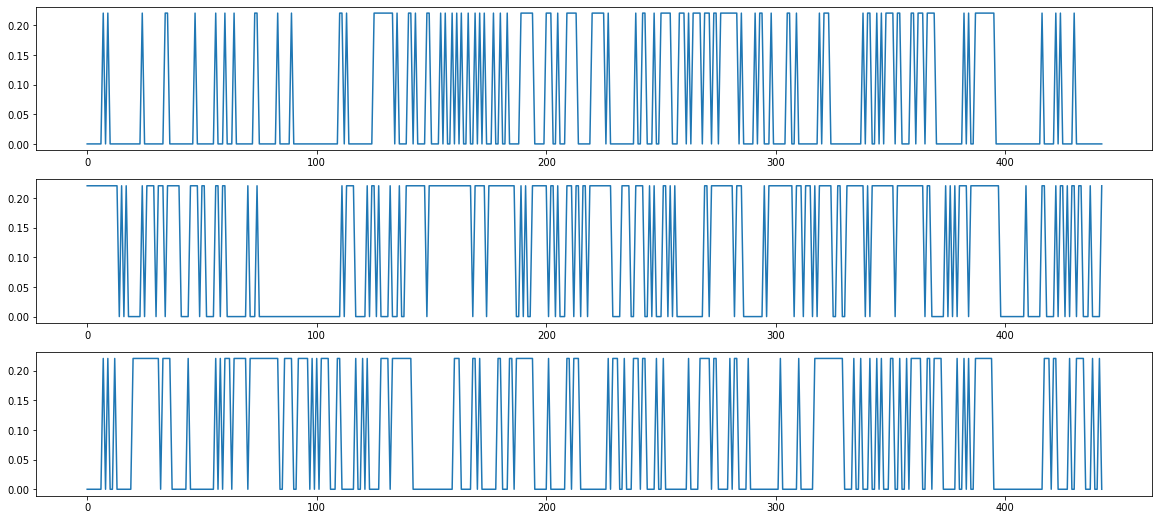

In [33]:
fig,ax = plt.subplots(figsize=[20,3*Nfilters],nrows=Nfilters)

for i in range(Nfilters):
    ax[i].plot(binmodel.weights[0][:,i])